# Deep Learning Final Project

### Import Libraries

In [ ]:
import zipfile
import os
import random
from tqdm.notebook import tqdm

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tt
from torchvision.io import read_image
from torchvision.utils import make_grid
from torchsummary import summary
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from skimage import io, transform
from sklearn.metrics.pairwise import cosine_similarity

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
print(torch.__version__)

1.9.0+cu102


# Task 2: ReID

### Global Vars

In [ ]:
batch_size = 32
epochs = 100

### Import input data

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


Set data folder path here

In [ ]:
current_folder_path = '/content/drive/MyDrive/Colab Notebooks/DL'
input_folder_path = '/content/drive/MyDrive/Colab Notebooks/DL/data-folder'
dataset_folder_path = input_folder_path + '/dataset'

Unzip dataset folder

In [ ]:
!unzip -q '/content/drive/MyDrive/Colab Notebooks/DL/data-folder/dataset'

In [ ]:
!ls

annotations_train.csv  drive  queries  sample_data  test  train


### Device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda', index=0)

## Statistics of training samples
We observe statistical properties of the training samples to determine the ideal number of images to retrieve for each query.

In [ ]:
# list of image file names
train_imgs = os.listdir('train')

train_imgs[:10]

['1304_c6_070585431.jpg',
 '1481_c5_024242228.jpg',
 '1062_c3_089462591.jpg',
 '1199_c5_061013173.jpg',
 '1481_c6_089229603.jpg',
 '1095_c5_033040791.jpg',
 '0164_c1_012602602.jpg',
 '1084_c2_026064203.jpg',
 '1411_c6_050520872.jpg',
 '0088_c3_030652467.jpg']

In [ ]:
# get the image id from it's file name
train_imgs_data = []
for s in train_imgs:
  train_imgs_data.append([int(s.split('_')[0]), s])

train_imgs_df = pd.DataFrame(train_imgs_data, columns=['id', 'filename'])

train_imgs_df.head()

,id,filename
0,1304,1304_c6_070585431.jpg
1,1481,1481_c5_024242228.jpg
2,1062,1062_c3_089462591.jpg
3,1199,1199_c5_061013173.jpg
4,1481,1481_c6_089229603.jpg


Now groupby id and count the number of images per person

In [ ]:
img_per_person = train_imgs_df.groupby('id')['filename'].count()
img_per_person

id
2        7
5       26
6       29
7       25
9       21
        ..
1493    27
1494    22
1497    22
1498    13
1501    17
Name: filename, Length: 751, dtype: int64

Plot statistics

In [ ]:
print('Max img of a person: ', img_per_person.max())
print('Min imag of a person: ', img_per_person.min())
print('Mean img of a person: ', img_per_person.mean())

Max img of a person:  72
Min imag of a person:  2
Mean img of a person:  17.29560585885486


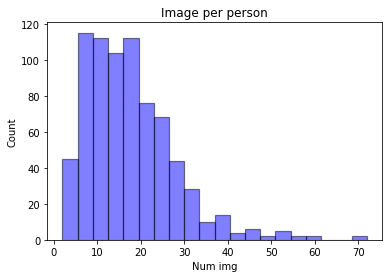

In [ ]:
plt.hist(img_per_person.values, facecolor='blue', bins=20, alpha=0.5, edgecolor='black', linewidth=1.2)
plt.title("Image per person")
plt.ylabel("Count")
plt.xlabel("Num img")
plt.show()

We can see here that most unique person_id has 5 to 28 images. Mean image per person is 17.2

In our opinion, retrieving **80 images** per query image could be a good number. 

In [ ]:
num_img_per_query = 100

## Data Loader

In [ ]:
ann_csv_path = 'annotations_train.csv'
annotations_train_csv = pd.read_csv(ann_csv_path)

annotations_train_csv.head()

,id,age,backpack,bag,handbag,clothes,down,up,hair,hat,gender,upblack,upwhite,upred,uppurple,upyellow,upgray,upblue,upgreen,downblack,downwhite,downpink,downpurple,downyellow,downgray,downblue,downgreen,downbrown
0,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1
1,857,2,1,2,1,2,2,2,2,1,2,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2
2,1487,2,2,1,1,2,2,2,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1
3,1422,2,1,2,1,2,2,2,1,1,1,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1
4,856,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1


In [ ]:
# imgs from the train folder
train_imgs = os.listdir('train')
# get the image id from it's file name
train_imgs_data = []
for s in train_imgs:
  train_imgs_data.append([int(s.split('_')[0]), s])

train_imgs_df = pd.DataFrame(train_imgs_data, columns=['id', 'filename'])

train_imgs_df.head()

,id,filename
0,1304,1304_c6_070585431.jpg
1,1481,1481_c5_024242228.jpg
2,1062,1062_c3_089462591.jpg
3,1199,1199_c5_061013173.jpg
4,1481,1481_c6_089229603.jpg


In [ ]:
annotations_train = pd.merge(annotations_train_csv, train_imgs_df, on='id')

# now we have filename column (last one) also inside the annotations dataframe
annotations_train

,id,age,backpack,bag,handbag,clothes,down,up,hair,hat,gender,upblack,upwhite,upred,uppurple,upyellow,upgray,upblue,upgreen,downblack,downwhite,downpink,downpurple,downyellow,downgray,downblue,downgreen,downbrown,filename
0,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c5_013563167.jpg
1,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c5_087766632.jpg
2,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c5_046017229.jpg
3,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c1_098614695.jpg
4,474,2,1,1,1,1,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,0474_c2_007717494.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12984,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c2_028331321.jpg
12985,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c6_001668358.jpg
12986,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c2_053033722.jpg
12987,1177,2,2,1,1,2,2,2,2,1,2,1,2,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1177_c3_037640775.jpg


In [ ]:
reid_train_annotations = annotations_train[['id', 'filename']]

#### Split train folder imgs into train and vaid
save as csv

In [ ]:
# get unique ids
unique_ids = reid_train_annotations.id.unique() 
# now we split ids into training and valid set
# last 100 is our validation data set
# the rest is for trining
valid_ids = unique_ids[-100:]
train_ids = unique_ids[:-100]

20.0% valid start at index: 10392


In [ ]:
print('Trining identities len: ', len(train_ids))
print('Validation identities len: ', len(valid_ids))

In [ ]:
# get valid mask
valid_mask = reid_train_annotations['id'].isin(valid_ids)

In [ ]:
# train dataframe (annotations)
train_df = reid_train_annotations.loc[~valid_mask]
train_df

In [ ]:
# valid dataframe (annotations)
valid_df = reid_train_annotations.loc[valid_mask]
valid_df

In [ ]:
# save them as csv
pd.DataFrame(train_df, columns=['id', 'filename']).to_csv('reid_train_annotations.csv', index=False)
pd.DataFrame(valid_df, columns=['id', 'filename']).to_csv('reid_val_annotations.csv', index=False)

### Custom Dataset

In [ ]:
class ReIdMarketDataset(Dataset):
  """ Market ReID dataset """

  def __init__(self, csv_file, root_dir, transform=None, has_id_info = False):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.annotations_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.has_id_info = has_id_info

  def __len__(self):
      return len(self.annotations_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    anchor_img_path = os.path.join(self.root_dir, str(self.annotations_frame.iloc[idx, -1]))
    anchor_img = io.imread(anchor_img_path)
    anchor_img_id = int(self.annotations_frame.iloc[idx, 0])
    anchor_img_filename = str(self.annotations_frame.iloc[idx, -1])

    pos_img_candidates = self.annotations_frame[self.annotations_frame['id']==anchor_img_id].index
    pos_img_idx = random.choice(pos_img_candidates)
    pos_img_path = os.path.join(self.root_dir, str(self.annotations_frame.iloc[pos_img_idx, -1]))
    pos_img = io.imread(pos_img_path)
    pos_img_id = int(self.annotations_frame.iloc[pos_img_idx, 0])
    pos_img_filename = str(self.annotations_frame.iloc[pos_img_idx, -1])

    neg_img_candidates = self.annotations_frame[self.annotations_frame['id']!=anchor_img_id].index
    neg_img_idx = random.choice(neg_img_candidates)
    neg_img_path = os.path.join(self.root_dir, str(self.annotations_frame.iloc[neg_img_idx, -1]))
    neg_img = io.imread(neg_img_path)
    neg_img_id = int(self.annotations_frame.iloc[neg_img_idx, 0])
    neg_img_filename = str(self.annotations_frame.iloc[neg_img_idx, -1])

    sample = {
        'anchor_image': anchor_img,
        'anchor_image_id': anchor_img_id,
        'anchor_image_path': anchor_img_path,
        'anchor_image_filename': anchor_img_filename,
        'positive_image': pos_img,
        'positive_image_id': pos_img_id,
        'positive_image_path': pos_img_path,
        'positive_image_filename': pos_img_filename,
        'negative_image': neg_img,
        'negative_image_id': neg_img_id,
        'negative_image_path': neg_img_path,
        'negative_image_filename': neg_img_filename
    }

    if self.transform:
        sample['anchor_image'] = self.transform(sample['anchor_image'])
        sample['positive_image'] = self.transform(sample['positive_image'])
        sample['negative_image'] = self.transform(sample['negative_image'])

    return sample

In [ ]:
tr_dataset = ReIdMarketDataset('reid_train_annotations.csv', 'train/')
val_dataset = ReIdMarketDataset('reid_val_annotations.csv', 'train/')

print('Train dataset len: ', len(tr_dataset))
print('Valid dataset len: ', len(val_dataset))

Train dataset len:  10380
Valid dataset len:  2609


### Data augmentation
Channel-wise normalization + Data augmentations

In [ ]:
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_tfms = tt.Compose([
    tt.ToPILImage(),
    tt.RandomCrop((128, 64), padding=8, padding_mode='reflect'),
#     tt.RandomResizedCrop(256, scale=(0.5,0.9), ratio=(1, 1)), 
#     tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    tt.RandomHorizontalFlip(p=0.5), 
    tt.RandomRotation(10),
    tt.ToTensor(), 
    tt.Normalize(*imagenet_stats,inplace=True), 
    tt.RandomErasing(p=0.5, inplace=True)
])

valid_tfms = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(*imagenet_stats)
])

### Data loader

In [ ]:
def get_data_loaders(train_csv, val_csv, batch_size=100):
  train_ds = ReIdMarketDataset(train_csv, 'train/', transform=train_tfms)
  val_ds = ReIdMarketDataset(val_csv, 'train/', transform=valid_tfms)

  train_dloader = torch.utils.data.DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
  valid_dloader = torch.utils.data.DataLoader(val_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return train_dloader, valid_dloader

In [ ]:
train_dloader, valid_dloader = get_data_loaders('reid_train_annotations.csv', 'reid_val_annotations.csv', batch_size=batch_size)

In [ ]:
def show_batch(dl):
  for data in dl:
    fig, ax = plt.subplots(figsize=(32, 16))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(data['anchor_image'][:32], nrow=8).squeeze().permute(1, 2, 0).clamp(0,1))
    break

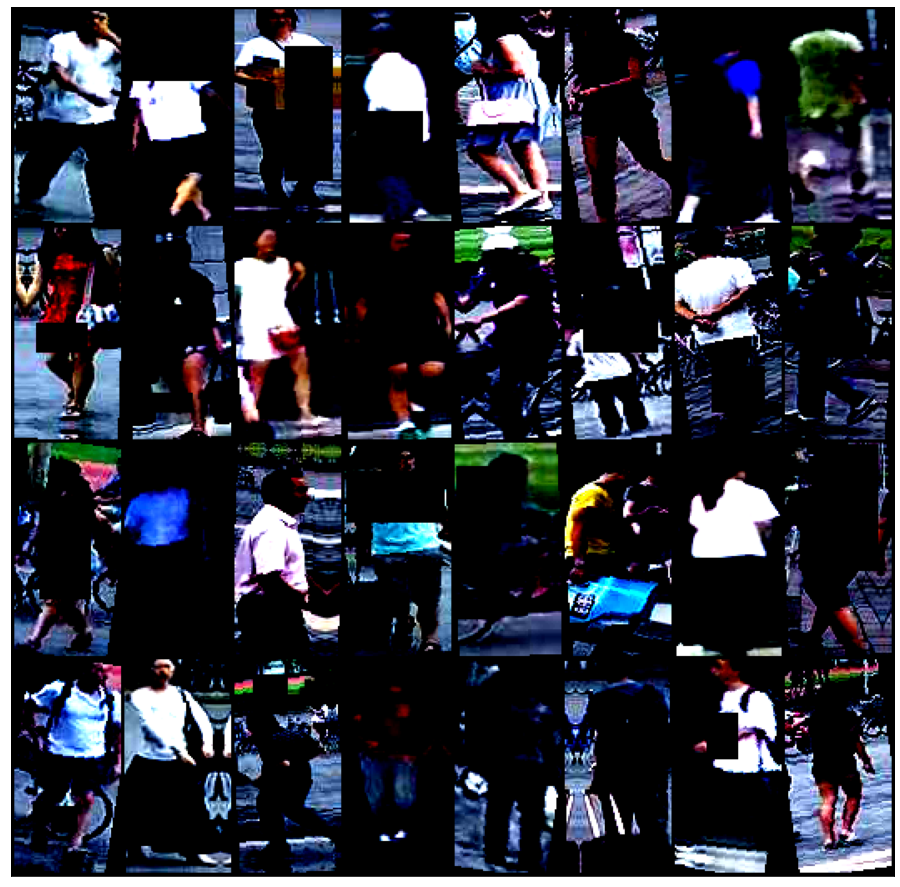

In [ ]:
show_batch(train_dloader)

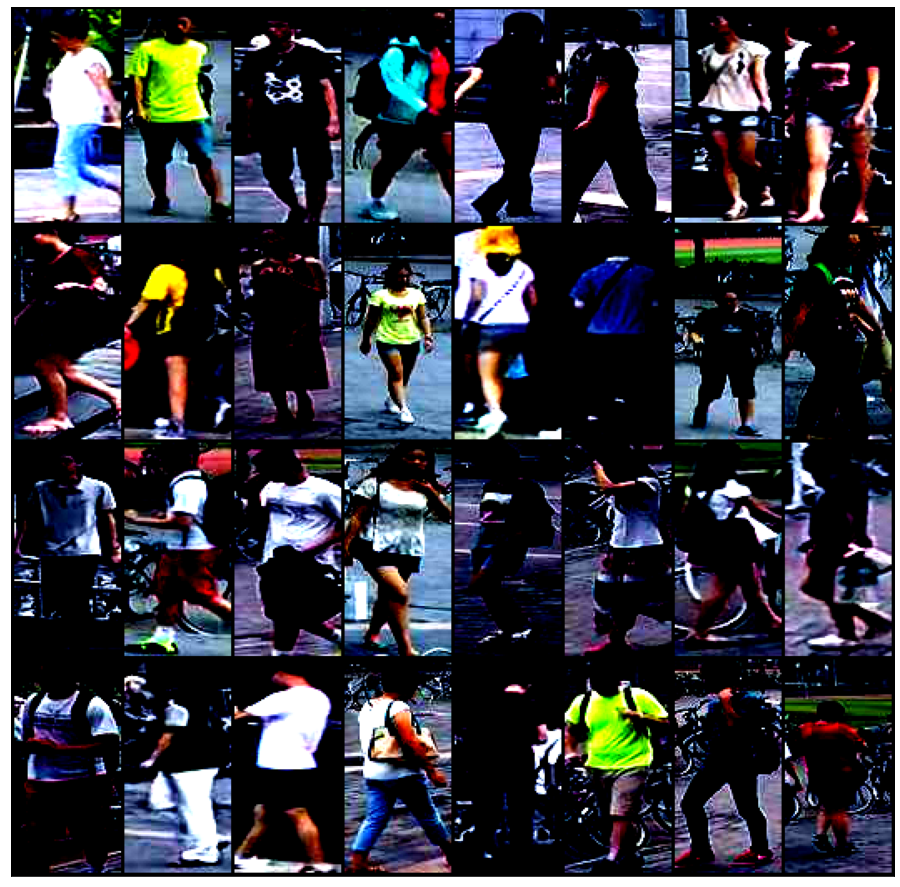

In [ ]:
show_batch(valid_dloader)

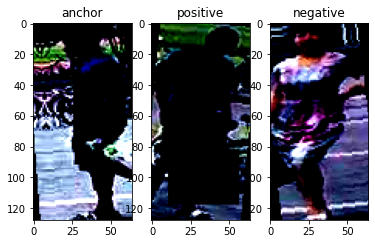

In [ ]:
temp = next(iter(train_dloader))
anc = temp["anchor_image"][0].squeeze().permute(1, 2, 0).clamp(0,1)
pos = temp["positive_image"][0].squeeze().permute(1,2,0).clamp(0,1)
neg = temp["negative_image"][0].squeeze().permute(1,2,0).clamp(0,1)
# show plot
fig, axs = plt.subplots(1,3)
axs[0].imshow(anc)
axs[0].title.set_text('anchor')
axs[1].imshow(pos)
axs[1].title.set_text('positive')
axs[2].imshow(neg)
axs[2].title.set_text('negative')

We have prepeared our dataset for training, now create the model

## ReID model
We simply take a pretrined ResNet50 and drop the last FC layer. This modified model will return a vector of feature values with size `2048`

In [ ]:
class ReIdResNet50(nn.Module):
    def __init__(self):
      super(ReIdResNet50, self).__init__()
      backbone = torchvision.models.resnet50(pretrained=True)
      self.fc_inputs = backbone.fc.in_features
      layers = list(backbone.children())[:-1]

      self.feature_extractor = nn.Sequential(*layers)

    def forward(self, x):
      f = self.feature_extractor(x)
      out = f.view(f.size(0), -1)

      return out

In [ ]:
model=ReIdResNet50().to(device)
summary(model, input_size=(3, 128, 64))

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 32]           9,408
       BatchNorm2d-2           [-1, 64, 64, 32]             128
              ReLU-3           [-1, 64, 64, 32]               0
         MaxPool2d-4           [-1, 64, 32, 16]               0
            Conv2d-5           [-1, 64, 32, 16]           4,096
       BatchNorm2d-6           [-1, 64, 32, 16]             128
              ReLU-7           [-1, 64, 32, 16]               0
            Conv2d-8           [-1, 64, 32, 16]          36,864
       BatchNorm2d-9           [-1, 64, 32, 16]             128
             ReLU-10           [-1, 64, 32, 16]               0
           Conv2d-11          [-1, 256, 32, 16]          16,384
      BatchNorm2d-12          [-1, 256, 32, 16]             512
           Conv2d-13          [-1, 256, 32, 16]          16,384
      BatchNorm2d-14          [-1, 256,

## Train ReID

### Training

In [ ]:
def reid_train_model(model, data_loader, cost_func, optimizer, device):
  model.train()

  # loss
  total_train_loss = 0.0

  batch_counter = 0

  for batch_idx, input_data in enumerate(data_loader):
    # reset gradiants to zero
    optimizer.zero_grad()

    # push input data to GPU
    anchor_img = input_data['anchor_image'].to(device)
    positive_img = input_data['positive_image'].to(device)
    negative_img = input_data['negative_image'].to(device)

    # get outputs (predictions) from the model
    anchor_outputs = model(anchor_img.float())
    positive_outputs = model(positive_img.float())
    negative_outputs = model(negative_img.float())

    # calculate loss
    loss = cost_func(anchor_outputs, positive_outputs, negative_outputs)

    # backward
    loss.backward()

    # update weights
    optimizer.step()

    # update total training loss
    total_train_loss += loss.item()
    batch_counter += 1

  batch_loss = total_train_loss/batch_counter
  return batch_loss

### Validation

In [ ]:
def reid_valid_model(model, data_loader, cost_func, device):
  model.eval()

  # loss
  total_valid_loss = 0.0

  batch_counter = 0

  with torch.no_grad():
    for batch_idx, input_data in enumerate(data_loader):
      anchor_img = input_data['anchor_image'].to(device)
      positive_img = input_data['positive_image'].to(device)
      negative_img = input_data['negative_image'].to(device)

      # get outputs (predictions) from the model
      anchor_outputs = model(anchor_img.float())
      positive_outputs = model(positive_img.float())
      negative_outputs = model(negative_img.float())

      # calculate loss
      loss = cost_func(anchor_outputs, positive_outputs, negative_outputs)

      # update total training loss
      total_valid_loss += loss.item()
      batch_counter += 1

    batch_loss = total_valid_loss/batch_counter
    return batch_loss

## Main

In [ ]:
def main(model, train_dloader, valid_dloader, cost_func, optimizer, batch_size=32, epochs=30, device='cuda:0', checkpoint_path='model.pth'):
  # early stopping details
  n_epochs_stop = 10
  min_val_loss = np.Inf
  epochs_no_improve = 0

  # tensorboard summary rriter
  from torch.utils.tensorboard import SummaryWriter
  writer_loss = SummaryWriter(log_dir="runs/loss")

  for epoch in range(epochs):
    print('-' * 20)
    print('| epoch {:3d}/{:3d}'.format(epoch +1, epochs))
    
    # training
    train_loss = reid_train_model(model, train_dloader, cost_func, optimizer, device)
    
    print_text = '| train_loss: {:.3f}'.format(train_loss)
    print(print_text)

    # validation
    valid_loss = reid_valid_model(model, valid_dloader, cost_func, device)

    print_text = '| valid_loss: {:.3f}'.format(valid_loss)
    print(print_text)

    # early stopping
    # If the validation loss is at a minimum
    if valid_loss < min_val_loss:
      # Save the model
      torch.save(model, checkpoint_path)
      epochs_no_improve = 0
      min_val_loss = valid_loss
      print('| model saved!')
      
    else:
      epochs_no_improve += 1
      # Check early stopping condition
      if epochs_no_improve == n_epochs_stop:
        print('| early stopping!')
        print('-' * 20)
        break
    print('-' * 20)

    # tensorboard
    writer_loss.add_scalar('Loss/train_loss', train_loss, epoch + 1)

    writer_loss.add_scalar('Loss/valid_loss', valid_loss, epoch + 1)

  # close writers
  writer_loss.close()

**Triplet Loss**

ref: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html

In [ ]:
cost_function = nn.TripletMarginWithDistanceLoss(swap=True)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)

In [ ]:
checkpoint_path = current_folder_path + '/reid_model_2_old.pth'

In [ ]:
main(model, train_dloader, valid_dloader, cost_function, optimizer, batch_size=batch_size, epochs=epochs, device=device, checkpoint_path = checkpoint_path)

--------------------
| epoch   1/100
| train_loss: 0.645
| valid_loss: 0.217
| model saved!
--------------------
--------------------
| epoch   2/100
| train_loss: 0.243
| valid_loss: 0.146
| model saved!
--------------------
--------------------
| epoch   3/100
| train_loss: 0.174
| valid_loss: 0.104
| model saved!
--------------------
--------------------
| epoch   4/100
| train_loss: 0.145
| valid_loss: 0.096
| model saved!
--------------------
--------------------
| epoch   5/100
| train_loss: 0.120
| valid_loss: 0.063
| model saved!
--------------------
--------------------
| epoch   6/100
| train_loss: 0.100
| valid_loss: 0.075
--------------------
--------------------
| epoch   7/100
| train_loss: 0.098
| valid_loss: 0.060
| model saved!
--------------------
--------------------
| epoch   8/100
| train_loss: 0.076
| valid_loss: 0.062
--------------------
--------------------
| epoch   9/100
| train_loss: 0.080
| valid_loss: 0.061
--------------------
--------------------
| epoch

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

In [ ]:
# reload best model
trained_model = torch.load(checkpoint_path)

## Validation set mAP evaluation

In [ ]:
# load classification valid data
valid_df = pd.read_csv('reid_val_annotations.csv')
valid_df

In [ ]:
# get unique IDs
unique_val = sorted(valid_df['id'].unique())
unique_val[:10]

In [ ]:
# for each unique id we create query list and it's ground truth
query_ids = []
valid_ground_truth_list = []
for id in unique_val:
  candidates = valid_df[valid_df['id']==id].index
  q_id = random.choice(candidates)
  q_filename = valid_df.iloc[q_id, -1]
  query_ids.append(q_id)
  # ground truth
  truth_vals = valid_df.loc[(valid_df['id']==id) & (valid_df['filename']!=q_filename)]
  truth_vals['query']=q_filename
  valid_ground_truth_list.extend(truth_vals[['query', 'filename']].values.tolist())

valid_ground_truth=pd.DataFrame(valid_ground_truth_list, columns=['query', 'pos_img'])
valid_ground_truth

In [ ]:
# transform in dict
valid_ground_truth = valid_ground_truth.groupby('query')['pos_img'].apply(list).to_dict()
valid_ground_truth

Now create query dataframe

In [ ]:
query_ids[:10]

In [ ]:
query_df = valid_df.iloc[query_ids, :]
query_df

In [ ]:
# create a list with filenames of query_img
query_filenames = query_df[['filename']].to_numpy()
query_filenames = query_filenames.reshape(-1)
query_filenames[:10]

We take valid dataloader, which has been used for trining.

Then for each img in data loader we will get embeddind (feature values)

In [ ]:
trained_model.eval()

valid_emb_values = []
img_names = []
img_ids = []
with torch.no_grad():
  for batch_idx, input_data in enumerate(tqdm(valid_dloader)):
    img = input_data['anchor_image'].to(device)
    img_filename = input_data['anchor_image_filename']
    img_id = input_data['anchor_image_id']
    outputs = trained_model(img.float())
    valid_emb_values.append(outputs.cpu().numpy())
    img_names.append(img_filename)
    img_ids.append(img_id)

valid_emb_values = np.concatenate(valid_emb_values)
img_names = np.concatenate(img_names)
img_ids = np.concatenate(img_ids)

In [ ]:
valid_emb_values_df = pd.DataFrame(valid_emb_values)
valid_emb_values_df['filename'] = img_names
valid_emb_values_df['id'] = img_ids
valid_emb_values_df

Now we have to extract query images from the `valid_emb_values_df` Dataframe

In [ ]:
query_emb_df = valid_emb_values_df.merge(query_df, how='inner', on='filename')
query_emb_df = query_emb_df.iloc[:, :-1]
query_emb_df

Now we have to extract test (gallery) images from the `valid_emb_values_df` Dataframe, which are all images from `valid_emb_values_df `which is not a query image

In [ ]:
gallery_emb_df  = valid_emb_values_df[~valid_emb_values_df['filename'].isin(query_emb_df['filename'])]
gallery_emb_df

Now we have `query_emb_df` and `gallery_emb_df`,
so we are ready to compare them to see which gallery imgs are more similer with query imgs.

We use `cosine_similarity` to compare.
Ref: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html

In [ ]:
validation_similarity_results = pd.DataFrame(cosine_similarity(query_emb_df.iloc[:,:-2], gallery_emb_df.iloc[:,:-2], dense_output=True))
validation_similarity_results

We can see that cosine_similarity has produced result after comparing query imgs with gallery imgs
- on axis_0 we have `query images`
- on axis_1 we have `gallery images`

Now foreach query img we have to select top 80 similer imgs

In [ ]:
valid_predictions = []
for idx in range(len(validation_similarity_results)):
  query_filename = query_emb_df.iloc[idx].filename
  top_similers_indexs = pd.DataFrame(validation_similarity_results.iloc[idx].sort_values(ascending=False)[:num_img_per_query]).index
  for _, index in enumerate(top_similers_indexs):
    similer_img = gallery_emb_df.iloc[index].filename
    valid_predictions.append([query_filename, similer_img])

valid_predictions = pd.DataFrame(valid_predictions, columns=['query', 'prediction'])
valid_predictions.sort_values(by=['query'])

In [ ]:
valid_predictions = valid_predictions.groupby('query')['prediction'].apply(list).to_dict()
valid_predictions

Finally we have both `ground truth` dictionary and `prediction` dictionary.
So, now we can compare them and calculate mAP value

In [ ]:
from typing import Dict, Set, List


class Evaluator:

    @staticmethod
    def evaluate_map(predictions: Dict[str, List], ground_truth: Dict[str, Set]):
        '''
        Computes the mAP (https://jonathan-hui.medium.com/map-mean-average-precision-for-object-detection-45c121a31173) of the predictions with respect to the given ground truth
        In person reidentification mAP refers to the mean of the AP over all queries.
        The AP for a query is the area under the precision-recall curve obtained from the list of predictions considering the
        ground truth elements as positives and the other ones as negatives

        :param predictions: dictionary from query filename to list of test image filenames associated with the query ordered
                            from the most to the least confident prediction.
                            Represents the predictions to be evaluated.
        :param ground_truth: dictionary from query filename to set of test image filenames associated with the query
                             Represents the ground truth on which to evaluate predictions.

        :return:
        '''

        m_ap = 0.0
        for current_ground_truth_query, current_ground_truth_query_set in ground_truth.items():

            # No predictions were performed for the current query, AP = 0
            if not current_ground_truth_query in predictions:
                continue

            current_ap = 0.0  # The area under the curve for the current sample
            current_predictions_list = predictions[current_ground_truth_query]

            # Recall increments of this quantity each time a new correct prediction is encountered in the prediction list
            delta_recall = 1.0 / len(current_ground_truth_query_set)

            # Goes through the list of predictions
            encountered_positives = 0
            for idx, current_prediction in enumerate(current_predictions_list):
                # Each time a positive is encountered, compute the current precition and the area under the curve
                # since the last positive
                if current_prediction in current_ground_truth_query_set:
                    encountered_positives += 1
                    current_precision = encountered_positives / (idx + 1)
                    current_ap += current_precision * delta_recall

            m_ap += current_ap

        # Compute mean over all queries
        m_ap /= len(ground_truth)

        return m_ap

m_ap = Evaluator.evaluate_map(valid_predictions, valid_ground_truth)
print('Validation set mAP score: ', m_ap)

## Testing ReID model
Now we have to test our model with testing data.

For testing we will use as query all the images from the `queries` folder and as gallery imgs we will use all images from `test` folder

In [ ]:
# query imgs
query_csv = 'queries.csv'
query_imgs = os.listdir('queries')
query_imgs=pd.DataFrame(query_imgs)
query_imgs.columns=['img_name']
query_imgs.to_csv(query_csv)

In [ ]:
# test imgs
test_csv = 'test.csv'
test_imgs = os.listdir('test')
test_imgs=pd.DataFrame(test_imgs)
test_imgs.columns=['img_name']
test_imgs.to_csv(test_csv)

In [ ]:
!ls

### Dataset

In [ ]:
class ReIdMarketDataset_singleImg(Dataset):
  """ Market ReID dataset """

  def __init__(self, csv_file, root_dir, transform=None, has_id_info = False):
    """
    Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.annotations_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
    self.has_id_info = has_id_info

  def __len__(self):
      return len(self.annotations_frame)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_name = str(self.annotations_frame.iloc[idx, 1])
    img_path = os.path.join(self.root_dir, img_name)
    img = io.imread(img_path)
    person_id = -1
    if self.has_id_info:
      person_id = int(self.annotations_frame.iloc[idx, 1].split('_')[0])

    sample = {
        'image': img,
        'image_filename': img_name,
        'image_path': img_path,
        'person_id': person_id
    }

    if self.transform:
        sample['image'] = self.transform(sample['image'])

    return sample

### Transformations

In [ ]:
reid_tfms = tt.Compose([
    tt.ToTensor(), 
    tt.Normalize(*imagenet_stats,inplace=True)
])

### Dataloader

In [ ]:
query_ds = ReIdMarketDataset_singleImg(query_csv, 'queries/', transform=reid_tfms)
query_dloader = torch.utils.data.DataLoader(query_ds, batch_size=32, num_workers=2, shuffle=True, pin_memory=True)
len(query_dloader)

In [ ]:
test_ds = ReIdMarketDataset_singleImg(test_csv, 'test/', transform=reid_tfms)
test_dloader = torch.utils.data.DataLoader(test_ds, batch_size=32, num_workers=2, shuffle=True, pin_memory=True)
len(test_dloader)

### Extract embedding values 

In [ ]:
from tqdm.notebook import tqdm
def extract_features(my_model, data_loader):
  my_model.eval()

  results = []
  img_names=[]
  with torch.no_grad():
      for _, inputs in enumerate(tqdm(data_loader)):
          input_img = inputs['image'].to(device)
          img_filename = inputs['image_filename']
          outputs = my_model(input_img.float())
          results.append(outputs.cpu().numpy())
          img_names.append(img_filename)

  results = np.concatenate(results)
  img_names = np.concatenate(img_names)

  results=pd.DataFrame(results)
  results['filename'] = img_names

  return results

#### Queries embedding values

In [ ]:
#Queries embedding values
queries_results = extract_features(trained_model, query_dloader)

In [ ]:
print(queries_results.shape)
queries_results

#### Test embedding values

In [ ]:
# Test embedding values
test_results = extract_features(trained_model, test_dloader)

In [ ]:
print(test_results.shape)
test_results

### Now compare **Queries embedding feature** values with **Test embedding feature** values

In [ ]:
test_similarities=pd.DataFrame(cosine_similarity(queries_results.iloc[:,:-1], test_results.iloc[:,:-1], dense_output=True))
test_similarities

Above dataframe contains Cosine similaritiy score.
- on axis_0 we have `query images`
- on axis_1 we have `test images`

Now we have to group these data by query image and take top 80 similer imgs as final result 

In [ ]:
final_predictions = {}
for idx in range(len(test_similarities)):
  top_similer_indexs = pd.DataFrame(test_similarities.iloc[idx].sort_values(ascending=False)[:num_img_per_query]).index
  top_similer_img_filenames = test_results.iloc[top_similer_indexs, -1].values.tolist()
  # for _, index in enumerate(top_similer_indexs):
  #   similer_img = test_results.iloc[index].filename
  #   final_predictions[][query_filename, similer_img]

  query_filename = queries_results.iloc[idx].filename
  final_predictions[query_filename] = top_similer_img_filenames
  
final_predictions

Finally ! we save our result as a txt file

In [ ]:
# output_txt_file_path = current_folder_path + '/reid_test_2_old.txt'

# with open(output_txt_file_path, 'a') as the_file:
#   for key, pred_list in final_predictions.items():
#     line = key + ': '
#     for _, filename in enumerate(pred_list):
#       line += filename + ', '

#     line = line[:-2]
#     the_file.write(line + '\n')

In [ ]:
# with open(output_txt_file_path) as f:
#     content = f.readlines()

# content

# [Extra]

Let's explore embedding space.
Here we take first 50 query images, then extract embedding values of each test images which have been preditect as query image by our model. Then we plot the embedding space using tensorboard Embdding Projector. Where we can apply PCA, T-SNE and UMAP to explore.

In [ ]:
# vectors = []
# metadata = []
# for idx in range(50):
#   top_similer_indexs = pd.DataFrame(test_similarities.iloc[idx].sort_values(ascending=False)[:num_img_per_query]).index
#   query_filename = queries_results.iloc[idx].filename
#   for _, index in enumerate(top_similer_indexs):
#     similer_img_vector = test_results.iloc[index, :-1].values.tolist()
#     vectors.append(similer_img_vector)
#     metadata.append(query_filename)
# vectors = np.array(vectors)

In [ ]:
# import numpy as np
# import tensorflow as tf
# import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter()
# writer.add_embedding(vectors, metadata)
# writer.close()

# %load_ext tensorboard
# %tensorboard --logdir=runs